# Note to self:

## draw histogram of each output for QLKNN and target to compare

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
import glob
import json

In [2]:
from scripts.QLKNN import QLKNN, QLKNNDataset
from scripts.utils import train_keys, target_keys

In [3]:
f = open("/share/rcifdata/jbarr/UKAEAGroupProject/data/test_loss_epoch_vs_step_chart_data")
test_loss = json.load(f)
f.close()

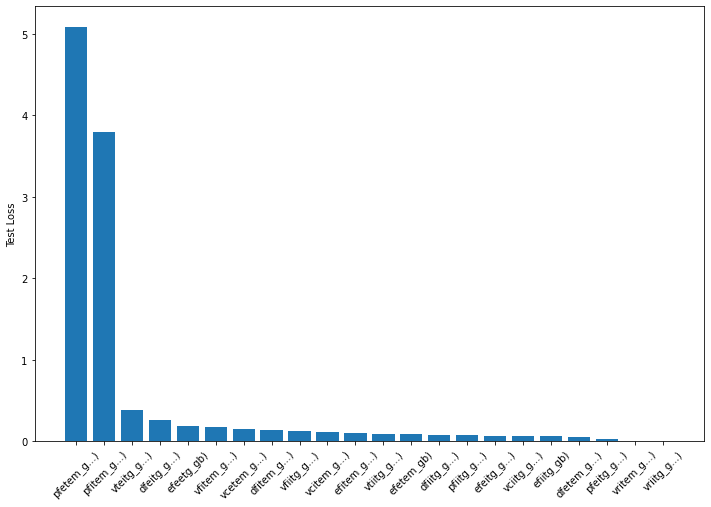

In [4]:
labels = []
out = []
for test in test_loss:
    experiment_name = test['name']
    x = experiment_name.split('-')
    labels.append(x[-1])
    out.append(test['y'][0])

x_points = np.arange(len(labels))

out = np.array(out)
sort_idx = np.argsort(np.array(out))[::-1]


out = out[sort_idx]

labels = np.array(labels)
labels = labels[sort_idx]

plt.figure(figsize = (12,8))
plt.bar(x_points, out)
plt.xticks(x_points, labels);
plt.xticks(rotation = 45);
plt.ylabel("Test Loss");

In [6]:
!ls /share/rcifdata/jbarr/UKAEAGroupProject/

build  grid_search	   lightning_logs  README.md	     src
data   grid_search_torch   logs		   requirements.txt  submit.sh
dist   input_output_model  pyproject.toml  setup.cfg


/tmp/ipykernel_68424/1468561582.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


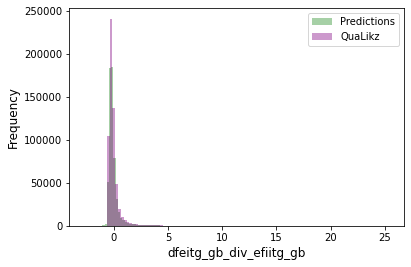

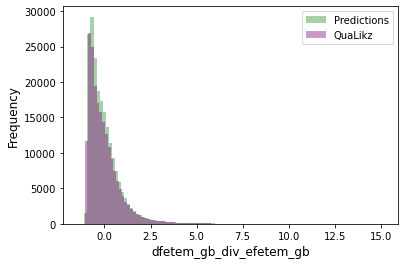

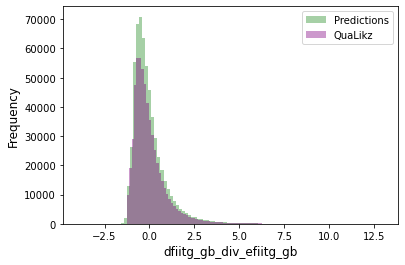

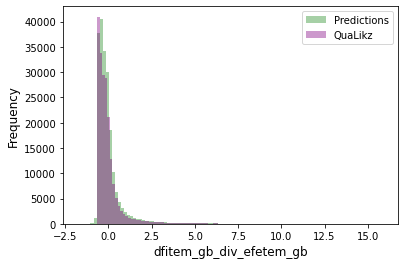

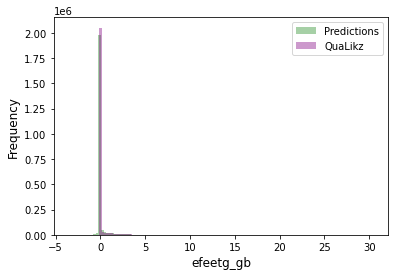

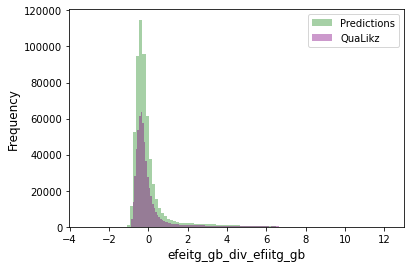

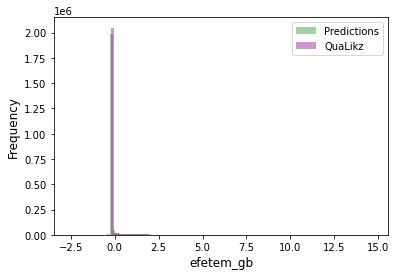

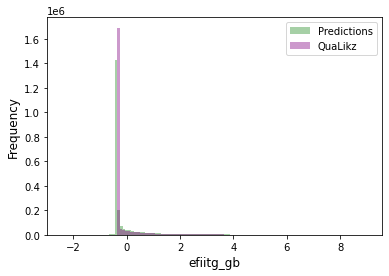

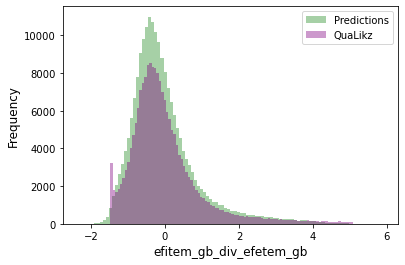

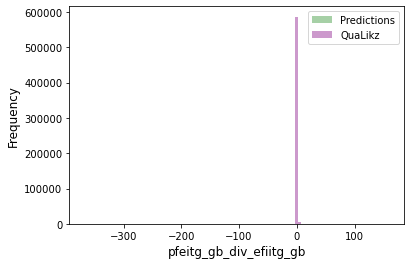

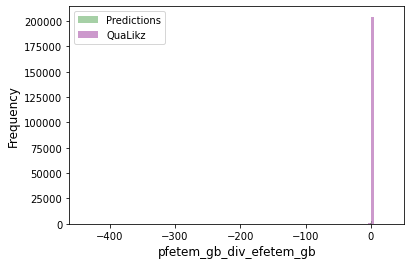

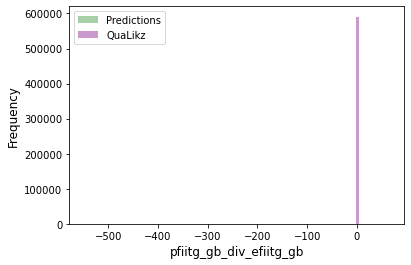

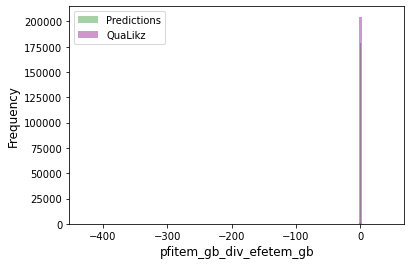

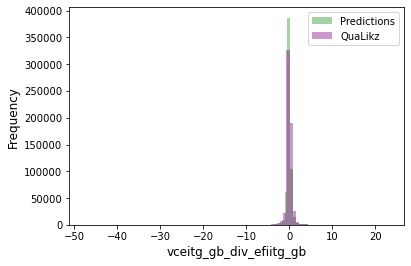

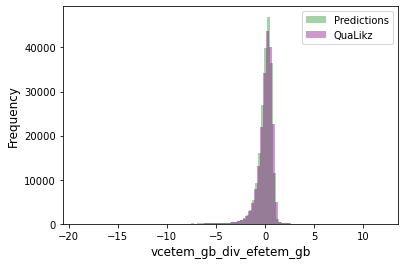

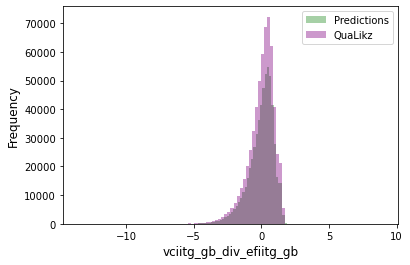

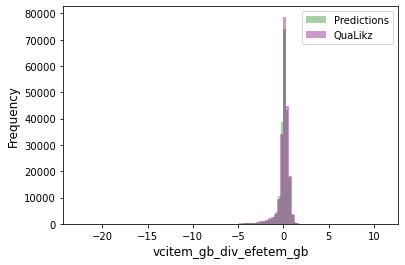

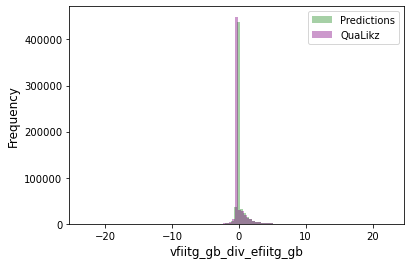

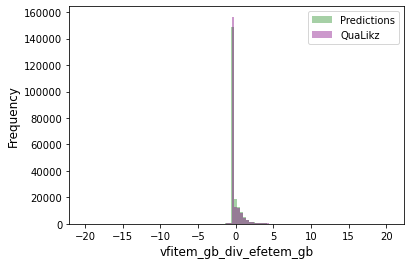

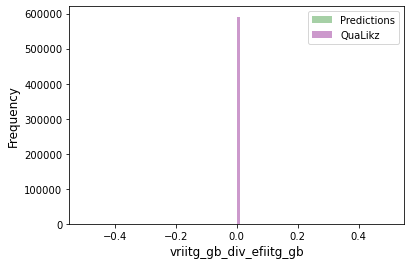

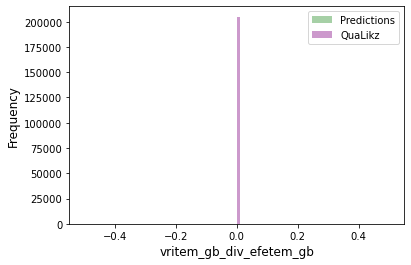

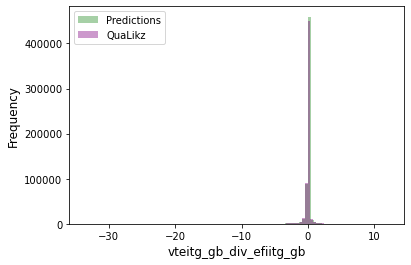

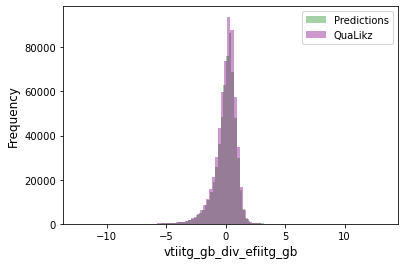

In [31]:
#test_data_path = "../../data/QLKNN_test_data.pkl"
test_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl"
train_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
predictions_list = []

for target in target_keys:
    path = glob.glob(f"/share/rcifdata/jbarr/UKAEAGroupProject/logs/QLKNN-Regressor/Run-6/Run-6-{target}/*.ckpt")[0]
    model = QLKNN.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 25, learning_rate = 0.002)
    
    train_data = QLKNNDataset(test_data_path, columns = train_keys + [target], train = True)
    train_data.scale()

    test_data = QLKNNDataset(test_data_path, columns = train_keys + [target], train = False)
    test_data.scale()

    test_loader = DataLoader(test_data, batch_size = 2048, shuffle = True, num_workers = 1)
    
    y = test_data.data[target]
    y = torch.tensor(y.values)
    X = test_data.data[train_keys]
    X = torch.tensor(X.values)
    
    predictions = model(X).detach().numpy()
    predictions_list.append(predictions)
    
    plt.figure()
    
    plt.hist(predictions, bins = 100, color = 'forestgreen',
             label = "Predictions", alpha = 0.4)# range = (predictions.min(), 6))
    plt.hist(test_data.data[target], bins = 100,
             label = "QuaLikz", color = 'purple', alpha = 0.4)# range = (predictions.min(), 6))
    plt.xlabel(target, fontsize = 12)
    plt.ylabel('Frequency', fontsize = 12)
    plt.legend()

In [ ]:
predictions_numpy = predictions.squeeze()

random_variable = test_data.data[train_keys[3]].to_numpy()

predictions_dict = {'x': random_variable, 'y': predictions_numpy}
predictions_df = pd.DataFrame(data = predictions_dict)
predictions_df['type'] = 'QLKNN'

target_dict = {'x': random_variable, 'y': test_data.data[target]}
target_df = pd.DataFrame(data = target_dict)
target_df['type'] = 'target'

plot_df = pd.concat([predictions_df.sample(5_000), target_df.sample(5_000)], axis = 0, ignore_index = True)

plot_df

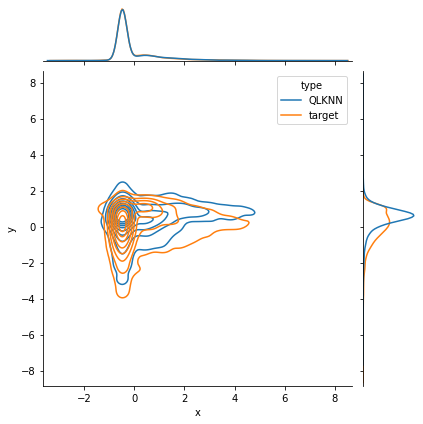

In [17]:
sns.jointplot(data = plot_df, x = 'x', y = 'y', hue = 'type', kind = 'kde')

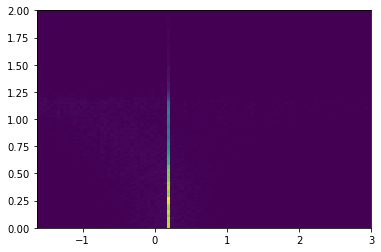

In [14]:
plt.figure()

x = test_data.data[train_keys[5]]
y = test_data.data[target]

x_range = [x.min(), x.mean() + 3*x.std()]
y_range = [y.mean(), y.mean() + 2*y.std()]

plt.hist2d(test_data.data[train_keys[6]], test_data.data[target], range = [x_range, y_range], bins = 100);

/home/jbarr/.conda/envs/UKAEA/lib/python3.9/site-packages/seaborn/axisgrid.py:1670: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


MemoryError: Unable to allocate 264. GiB for an array with shape (35375214889,) and data type int64

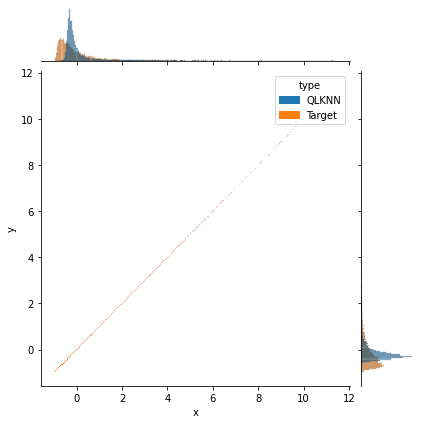

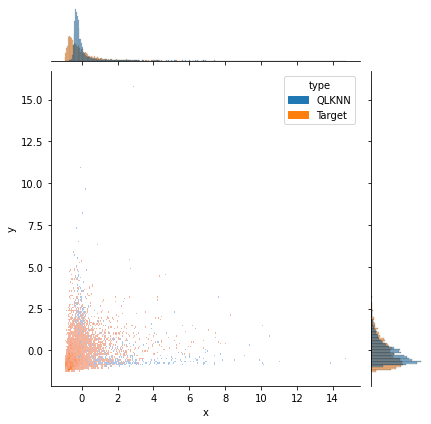

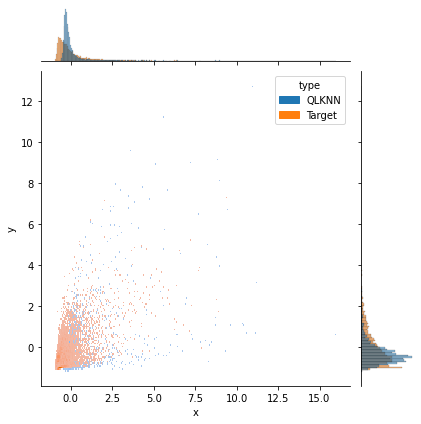

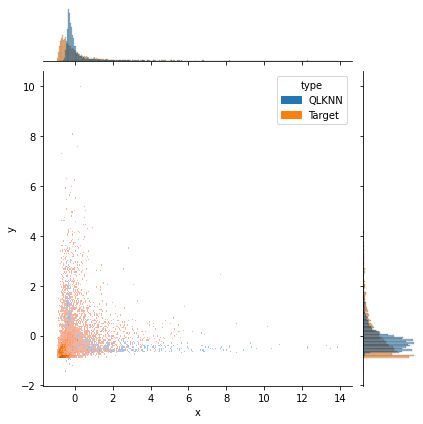

Error in callback <function flush_figures at 0x7efbca13bca0> (for post_execute):


KeyboardInterrupt: 

In [30]:
for i in range(len(target_keys)):
    for j in range(len(target_keys)):
        predict_x = predictions_list[i].squeeze()
        var_x = test_data.data[target_keys[i]].to_numpy()
        
        predict_y = predictions_list[j].squeeze()
        var_y = test_data.data[target_keys[j]].to_numpy()
        
        predictions_dict = {'x': predict_x, 'y': predict_y}
        predictions_df = pd.DataFrame(data = predictions_dict)
        predictions_df['type'] = 'QLKNN'
        
        var_dict = {'x': var_x, 'y': var_y}
        var_df = pd.DataFrame(data = var_dict)
        var_df['type'] = 'Target'
        
        plot_df = pd.concat([predictions_df.sample(5_000), var_df.sample(5_000)], axis = 0, ignore_index = True)
        
        sns.jointplot(data = plot_df, x = 'x', y = 'y', hue = 'type', kind = 'hist')